# Wärme Rohr 1D 24.07.2024

In [75]:
import numpy as np
import matplotlib.pyplot as plt 
import math 
import pandas as pd
from objdict import ObjDict
from FEMesh import *
from functions import *
import scipy.sparse as sp
from scipy.linalg import inv
from scipy.integrate import solve_ivp

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Numerische Lösung 

\begin{aligned}
& C \cdot v \cdot \sum_{\mathrm{j}} \int_0^1 \varphi_{\mathrm{j}} \cdot \varphi_{\mathrm{i}} \, dx \cdot \mathrm{T}_{\mathrm{j}}(t)
+ \mathrm{C} \cdot \mathrm{v} \cdot \sum_{\mathrm{j}} \int_0^1 \varphi_{\mathrm{j}} \cdot \varphi_{\mathrm{i}} \, dx \cdot \mathrm{T}_{\mathrm{j}}(t) \\
& + \alpha \cdot \varphi_{\mathrm{i}}(0) \cdot \varphi_{\mathrm{j}}(0) \cdot \mathrm{T}_{\mathrm{j}}(t) 
= \alpha \cdot \widehat{\mathrm{T}} \cdot \varphi_{\mathrm{i}}(0) + \mathrm{q} \cdot \int_0^1 \varphi_{\mathrm{i}} \, dx
\end{aligned}



\begin{gathered}
Gleichung: \mathrm{M} \cdot \mathrm{T}+\mathrm{A} \cdot \mathrm{T}=\mathrm{r} \\
\\
Mit: \\
\mathrm{M}_{\mathrm{ij}}=\int \varphi_{\mathrm{j}} \cdot \varphi_{\mathrm{i}} \\
\mathrm{A}_{\mathrm{ij}}=\int \varphi_{\mathrm{i}} \cdot \varphi_{\mathrm{j}}^{\prime} \mathrm{dx}+\alpha \cdot \mathrm{S}_{\mathrm{ij}} \\
\mathrm{S}_{\mathrm{ij}}=1(\text { for } \mathrm{i}=\mathrm{j}=1) \\
\mathrm{S}_{\mathrm{ij}}=0
\end{gathered}

## Programmierung der numerischen 1D Lösung 

### Funktionen

In [76]:
def compute_M(n, l, C):
    M = np.zeros((n, n))
    h = l / (n - 1)
    for i in range(n):
        for j in range(n):
            if i == j:
                M[i, j] = C * h / 3
            if abs(i - j) == 1:
                M[i, j] = C * h / 6
    return M

# def compute_A_old(n, l, C, v, alpha):
#     A = np.zeros((n, n))
#     h = l / (n - 1)
#     for i in range(n):
#         for j in range(n):
#             if i == j:
#                 A[i, j] = C * v / h + (alpha if i == 0 and j == 0 else 0)
#             if abs(i - j) == 1:
#                 A[i, j] = -C * v / h / 2
#     return A

def compute_A(n, l, C, v, alpha):
    A = np.zeros((n, n))
    h = l / (n - 1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i, j] = C * v / h + (alpha if i == 0 else 0)
            elif i == j + 1:
                A[i, j] = -C * v / h  # Forward difference (i > j)
            elif i == j - 1:
                A[i, j] = 0  # No backward difference (asymmetry)
    return A

def compute_S(n, alpha):
    S = np.zeros((n, n))
    S[0, 0] = alpha
    return S

def compute_r(n, l, q, T0, alpha):
    r = np.zeros(n)
    r[0] = alpha * T0
    h = l / (n - 1)
    for i in range(n):
        r[i] += q * h / 2  
    return r

### Constants

In [77]:
A = 0.00114  # m^2
c = 4190     # SHC J/kg*K
rho = 1000   # kg/m^3
C = A * rho * c #Simplify
v = 1       # Velocity m/s
l = 1        # Rod Length
n = 10       # Nodes

T = np.zeros(n)
T[0] = 20  # Initial condition at x = 0, 20 degrees Celsius

### Temperatur Stationär

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


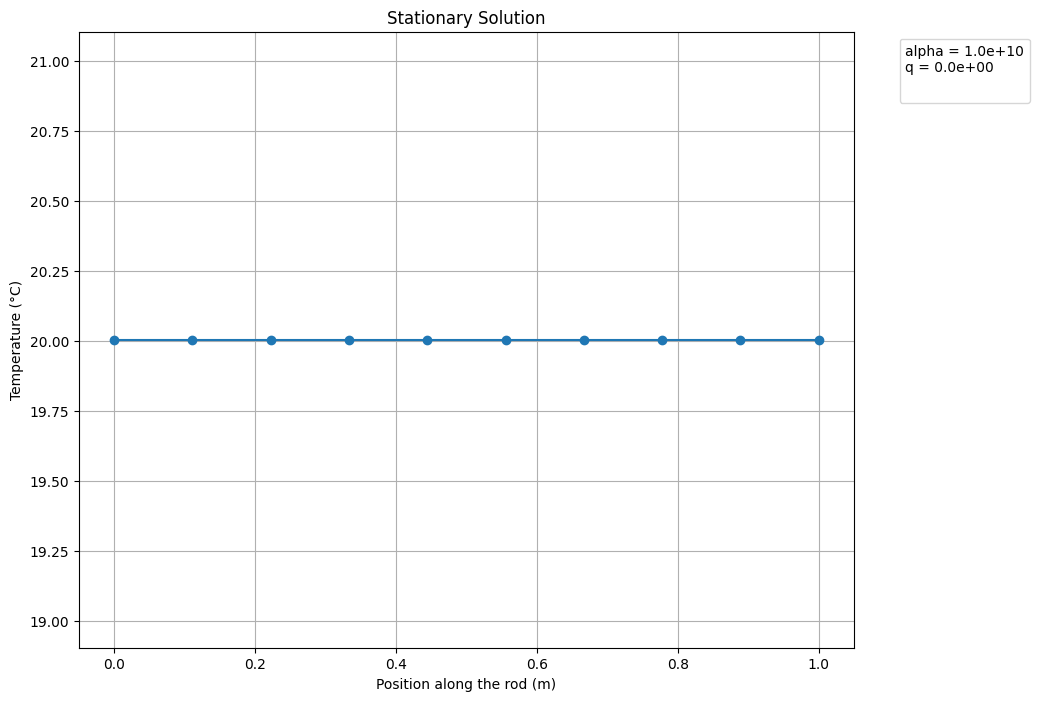

In [94]:
alpha = 1e10 # Penalty factor
q = 0   # Heat flow W/m

M = compute_M(n, l, C)
A = compute_A(n, l, C, v, alpha)
r = compute_r(n, l, q, T[0], alpha)
S = compute_S(n,alpha)

x = np.linspace(0, l, n)  # Node positions along the rod
T_stationary = np.linalg.solve(A, r)

plt.figure(figsize=(10, 8))
plt.plot(x, T_stationary, label='', marker='o')
plt.title(f'Stationary Solution')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
legend_title = f'alpha = {alpha:.1e}\nq = {q:.1e}\n'
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



### Penatly Factor alpha Trials

In [79]:
# q = 1e2   # Heat flow W/m

# alpha_values = [10**i for i in range(11)]  # alpha  1 to 1e10
# alpha_trial_results = pd.DataFrame(columns=['alpha'] + [f'T_{i}' for i in range(1, n+1)])

# for alpha in alpha_values:
#     A = compute_A(n, l, C, v, alpha)
#     r = compute_r(n, l, q, 20, alpha)
    
#     T_stationary = np.linalg.solve(A, r)
#     T_stationary = np.round(T_stationary,3)

#     new_row = pd.DataFrame([[alpha] + T_stationary.tolist()], columns=alpha_trial_results.columns)
#     alpha_trial_results = pd.concat([alpha_trial_results, new_row], ignore_index=True) #append results

# print(alpha_trial_results)


## Instationärer Fall Implizit Euler

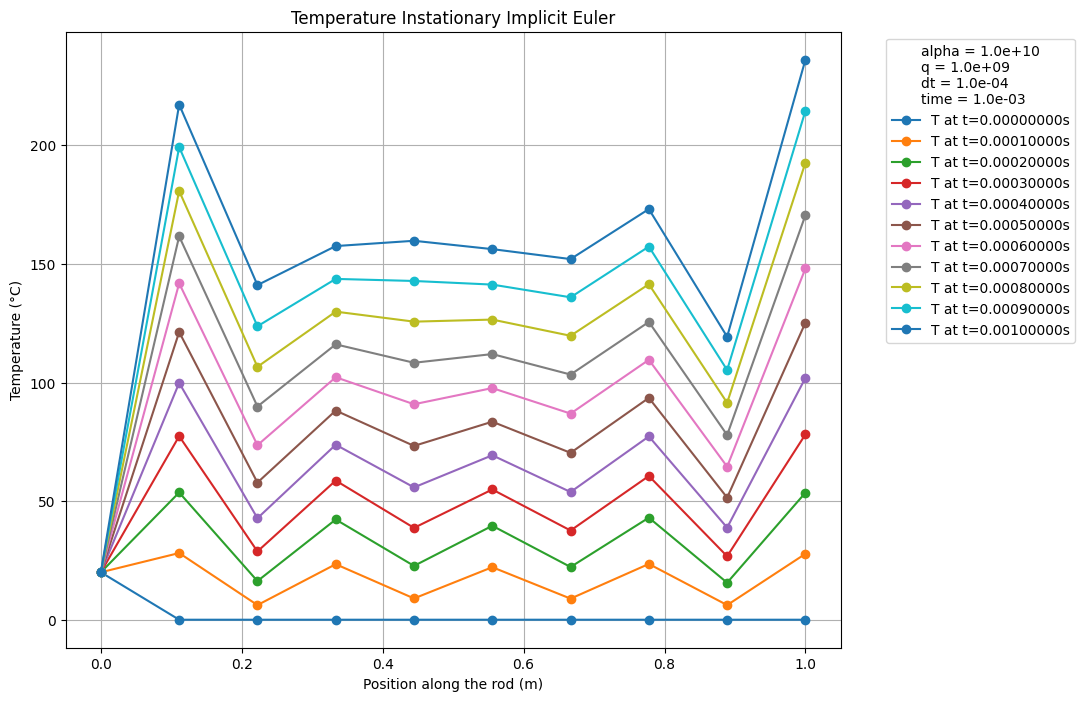

In [90]:
q = 1e9  # Heat flow W/m
alpha = 1e10 # Penalty factor
T = np.zeros(n)
T[0] = 20  # Initial condition at x = 0, 20 degrees Celsius

M = compute_M(n, l, C)
A = compute_A(n, l, C, v, alpha)
r = compute_r(n, l, q, T[0], alpha)
S = compute_S(n,alpha)

dt = 1/1e4
time = 1/1e3
n_steps = int(time / dt)

temperature_t = np.zeros((n_steps + 1, n))
temperature_t[0, :] = T

for step in range(1, n_steps + 1):
    gleichung_links = M + dt * A  
    gleichung_rechts = M @ T + dt * r 
    T = np.linalg.solve(gleichung_links, gleichung_rechts)  
    temperature_t[step, :] = T  #store result

x = np.linspace(0, l, n)  #node Positions
plt.figure(figsize=(10, 8))
for i in range(n_steps + 1):
    plt.plot(x, temperature_t[i, :], label=f'T at t={i*dt:.8f}s', marker='o')



plt.title(f'Temperature Instationary Implicit Euler')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
legend_title = f'alpha = {alpha:.1e}\nq = {q:.1e}\ndt = {dt:.1e}\ntime = {time:.1e}'
plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()



Hier gebe ich beim impliziten Euler Verfahren t als "quasi" unendlich an. Im Vergleich mit der instationären Lösung (siehe oben) passt das Ergebnis gut

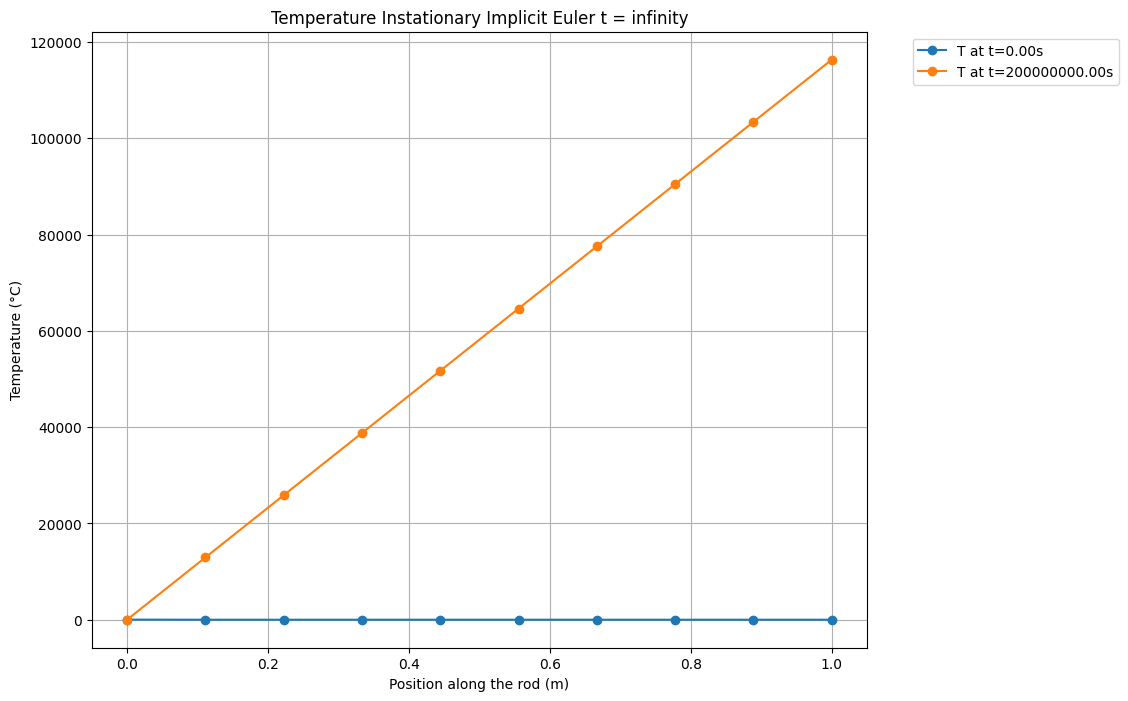

In [81]:
dt = 200000000
time = 200000000
n_steps = int(time / dt) 

T = np.zeros(n)
T[0] = 20  # Initial condition 
temperature_profile = np.zeros((n_steps + 1, n))
temperature_profile[0, :] = T


for step in range(1, n_steps + 1):
    gleichung_links = M + dt * A  
    gleichung_rechts = M @ T + dt * r 
    T = np.linalg.solve(gleichung_links, gleichung_rechts)  
    temperature_profile[step, :] = T  #store result

x = np.linspace(0, l, n)  #node Positions



plt.figure(figsize=(10, 8))
for i in range(n_steps + 1):
    plt.plot(x, temperature_profile[i, :], label=f'T at t={i*dt:.2f}s', marker='o')
plt.title('Temperature Instationary Implicit Euler t = infinity')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Solve using Scipy

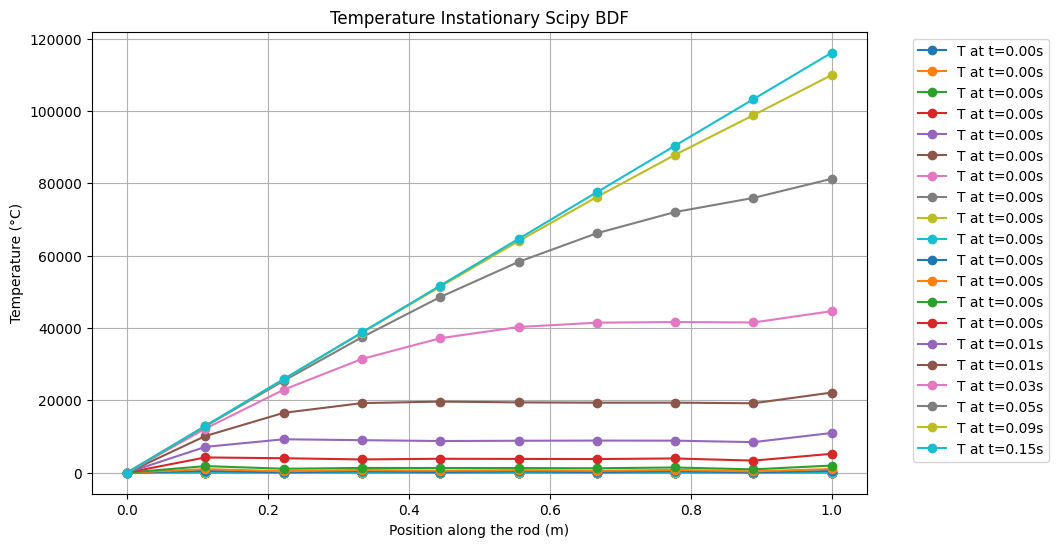

In [82]:

def F(t, T):
    return inv(M) @ (r - A @ T)

t0 = np.zeros(n)
t0[0] = 20 

solution = solve_ivp(F, [0, 0.2], t0, method='BDF', max_step=0.05)

x = np.linspace(0, l, n) 

plt.figure(figsize=(10, 6))
for i in range(0, len(solution.t), 5):  # Plot every 5th time step
    plt.plot(x, solution.y[:, i], marker='o', label=f'T at t={solution.t[i]:.2f}s')

plt.title('Temperature Instationary Scipy BDF')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# def F(t, T):
#     return inv(M) @ (r - A @ T)

# t0 = np.zeros(n)
# t0[0] = 20

# methods = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
# solutions = {}

# for method in methods:
#     sol = solve_ivp(F, [0, 0.2], t0, method=method, max_step=0.05)
#     solutions[method] = sol

# x = np.linspace(0, l, n)  # Node positions along the rod

# for method, sol in solutions.items():
#     plt.figure(figsize=(10, 8))
#     for i in range(0, len(sol.t), max(1, len(sol.t)//10)):  # Plot every 10th time step or at least 1 step
#         plt.plot(x, sol.y[:, i], marker='o', label=f'T at t={sol.t[i]:.2f}s')
#     plt.title(f'Temperature Instationary Scipy {method}')
#     plt.xlabel('Position along the rod (m)')
#     plt.ylabel('Temperature (°C)')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True)
#     plt.show()
